# NB03: Module-Level Co-inheritance Analysis

For organisms with ICA module data, test whether genes in the same module
co-occur more than expected. This validates the pairwise cofit results
using multi-gene coordinated regulation.

**Runs locally.** Requires NB01 data + `fitness_modules` project data.

### Key questions
1. Do within-module gene pairs have higher phi than random pairs?
2. Are the 48 accessory modules especially co-inherited?
3. Does module size or core fraction predict co-inheritance strength?

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path
from itertools import combinations
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

DATA_DIR = Path('../data')
CONS_DIR = Path('../../conservation_vs_fitness/data')
MODULE_DIR = Path('../../fitness_modules/data/modules')
MODCONS_DIR = Path('../../module_conservation/data')
FIGURES_DIR = Path('../figures')
FIGURES_DIR.mkdir(exist_ok=True)

# Load shared data
link = pd.read_csv(CONS_DIR / 'fb_pangenome_link.tsv', sep='\t')
link = link[link['orgId'] != 'Dyella79']
link['locusId'] = link['locusId'].astype(str)

# Module organisms that are also in our target set
MODULE_ORGANISMS = ['Koxy', 'Btheta', 'Putida', 'Korea', 'Phaeo', 'pseudo3_N2E3']

# Only process organisms with extracted presence matrices
available = [org for org in MODULE_ORGANISMS
             if (DATA_DIR / 'genome_cluster_matrices' / f'{org}_presence.tsv').exists()]
print(f"Module organisms with presence data: {len(available)}/{len(MODULE_ORGANISMS)}")
print(f"Available: {available}")

# Load module conservation data
modcons = pd.read_csv(MODCONS_DIR / 'module_conservation.tsv', sep='\t')
print(f"Module conservation data: {len(modcons)} modules")

Module organisms with presence data: 6/6
Available: ['Koxy', 'Btheta', 'Putida', 'Korea', 'Phaeo', 'pseudo3_N2E3']
Module conservation data: 1008 modules


## Helper Functions

In [2]:
def compute_phi(vec_a, vec_b):
    """Phi coefficient between two binary vectors."""
    if vec_a.std() == 0 or vec_b.std() == 0:
        return np.nan
    return np.corrcoef(vec_a, vec_b)[0, 1]


def module_coinheritance(matrix_np, cluster_indices):
    """Compute mean pairwise phi for a set of cluster indices."""
    if len(cluster_indices) < 2:
        return np.nan
    phis = []
    for i, j in combinations(cluster_indices, 2):
        phi = compute_phi(matrix_np[:, i], matrix_np[:, j])
        if not np.isnan(phi):
            phis.append(phi)
    return np.mean(phis) if phis else np.nan


def null_coinheritance(matrix_np, prevalence, target_prevs, n_genes, n_null=100, rng=None):
    """Generate null distribution of mean pairwise phi for prevalence-matched random gene sets."""
    if rng is None:
        rng = np.random.default_rng(42)
    
    all_clusters = np.arange(matrix_np.shape[1])
    null_scores = []
    
    for _ in range(n_null):
        # Sample random clusters with similar prevalence distribution
        sampled = []
        for tp in target_prevs:
            candidates = all_clusters[np.abs(prevalence - tp) < 0.05]
            if len(candidates) > 0:
                sampled.append(rng.choice(candidates))
        
        if len(sampled) >= 2:
            score = module_coinheritance(matrix_np, sampled)
            if not np.isnan(score):
                null_scores.append(score)
    
    return null_scores

## Per-Organism Module Co-inheritance

In [3]:
rng = np.random.default_rng(42)
all_module_results = []

for orgId in available:
    print(f"\n{'='*60}")
    print(f"Processing {orgId}")
    print(f"{'='*60}")

    # Load presence matrix
    matrix = pd.read_csv(
        DATA_DIR / 'genome_cluster_matrices' / f'{orgId}_presence.tsv',
        sep='\t', index_col=0
    )
    matrix_np = matrix.values.astype(np.int8)
    cluster_cols = matrix.columns.values
    cluster_idx = {c: i for i, c in enumerate(cluster_cols)}
    prevalence = matrix_np.sum(axis=0) / matrix_np.shape[0]

    # Load module membership
    mem_path = MODULE_DIR / f'{orgId}_gene_membership.csv'
    if not mem_path.exists():
        print(f"  No module data for {orgId}")
        continue

    mem = pd.read_csv(mem_path)
    module_cols = [c for c in mem.columns if c.startswith('M')]
    melted = mem.melt(id_vars='locusId', value_vars=module_cols,
                      var_name='module', value_name='member')
    melted = melted[melted['member'] == 1].drop(columns='member')
    melted['locusId'] = melted['locusId'].astype(str)

    # Map locus -> cluster
    org_link = link[link['orgId'] == orgId][['locusId', 'gene_cluster_id']].copy()
    org_link['locusId'] = org_link['locusId'].astype(str)
    locus_to_cluster = dict(zip(org_link['locusId'], org_link['gene_cluster_id']))

    melted['cluster'] = melted['locusId'].map(locus_to_cluster)
    melted = melted.dropna(subset=['cluster'])
    melted = melted[melted['cluster'].isin(cluster_idx)]

    print(f"  Module genes mapped to clusters: {len(melted)}")

    # Get module conservation info
    org_modcons = modcons[modcons['orgId'] == orgId].set_index('module')

    # Compute per-module co-inheritance
    modules = melted.groupby('module')['cluster'].apply(list).to_dict()

    for mod_name, mod_clusters in modules.items():
        # Get unique cluster indices
        unique_clusters = list(set(mod_clusters))
        indices = [cluster_idx[c] for c in unique_clusters if c in cluster_idx]

        if len(indices) < 2:
            continue

        # Mean pairwise phi
        score = module_coinheritance(matrix_np, indices)

        # Null distribution (1000 permutations for better p-value resolution)
        target_prevs = [prevalence[i] for i in indices]
        null_scores = null_coinheritance(
            matrix_np, prevalence, target_prevs, len(indices),
            n_null=1000, rng=rng
        )

        # P-value: fraction of null >= observed
        if null_scores and not np.isnan(score):
            pval = (np.sum(np.array(null_scores) >= score) + 1) / (len(null_scores) + 1)
            null_mean = np.mean(null_scores)
        else:
            pval = np.nan
            null_mean = np.nan

        # Module classification
        pct_core = org_modcons.loc[mod_name, 'pct_core'] if mod_name in org_modcons.index else np.nan
        if pct_core >= 90:
            mod_type = 'core_module'
        elif pct_core < 50:
            mod_type = 'accessory_module'
        else:
            mod_type = 'mixed'

        all_module_results.append({
            'orgId': orgId,
            'module': mod_name,
            'n_genes': len(indices),
            'mean_phi': score,
            'null_mean': null_mean,
            'delta': score - null_mean if not np.isnan(null_mean) else np.nan,
            'pval': pval,
            'pct_core': pct_core,
            'module_type': mod_type,
            'mean_prevalence': np.mean(target_prevs),
        })

    # Per-organism summary
    org_res = [r for r in all_module_results if r['orgId'] == orgId]
    if org_res:
        df = pd.DataFrame(org_res)
        sig = df[df['pval'] < 0.05]
        print(f"  Modules analyzed: {len(df)}")
        print(f"  Significant (p<0.05): {len(sig)} ({len(sig)/len(df)*100:.0f}%)")
        print(f"  Mean phi (all modules): {df['mean_phi'].mean():.4f}")
        print(f"  Mean null: {df['null_mean'].mean():.4f}")


Processing Koxy


  Module genes mapped to clusters: 1302


  Modules analyzed: 44
  Significant (p<0.05): 14 (32%)
  Mean phi (all modules): 0.0789
  Mean null: 0.0396

Processing Btheta
  Module genes mapped to clusters: 548


  Modules analyzed: 36
  Significant (p<0.05): 22 (61%)
  Mean phi (all modules): 0.1920
  Mean null: 0.0868

Processing Putida
  Module genes mapped to clusters: 1024


  Modules analyzed: 38
  Significant (p<0.05): 5 (13%)
  Mean phi (all modules): 0.2663
  Mean null: 0.2013

Processing Korea


  Module genes mapped to clusters: 666


  Modules analyzed: 29
  Significant (p<0.05): 1 (3%)
  Mean phi (all modules): 0.3566
  Mean null: 0.3165

Processing Phaeo
  Module genes mapped to clusters: 891


  Modules analyzed: 37
  Significant (p<0.05): 4 (11%)
  Mean phi (all modules): 0.1080
  Mean null: 0.0957

Processing pseudo3_N2E3
  Module genes mapped to clusters: 1304


  Modules analyzed: 40
  Significant (p<0.05): 5 (12%)
  Mean phi (all modules): 0.4435
  Mean null: 0.4063


## Results Summary

In [4]:
from statsmodels.stats.multitest import multipletests

if all_module_results:
    module_df = pd.DataFrame(all_module_results)

    # Apply Benjamini-Hochberg FDR correction
    valid = module_df.dropna(subset=['mean_phi', 'null_mean'])
    reject, pval_fdr, _, _ = multipletests(valid['pval'].values, method='fdr_bh')
    valid = valid.copy()
    valid['pval_fdr'] = pval_fdr
    valid['sig_fdr'] = reject

    # Merge FDR results back into full dataframe
    module_df = module_df.merge(
        valid[['orgId', 'module', 'pval_fdr', 'sig_fdr']],
        on=['orgId', 'module'], how='left'
    )
    module_df.to_csv(DATA_DIR / 'module_coinheritance.tsv', sep='\t', index=False)

    print(f"Total modules analyzed: {len(module_df)}")
    print(f"Organisms: {module_df['orgId'].nunique()}")

    # Overall
    valid = module_df.dropna(subset=['mean_phi', 'null_mean'])
    print(f"\n=== OVERALL ===")
    print(f"  Mean within-module phi: {valid['mean_phi'].mean():.4f}")
    print(f"  Mean null phi: {valid['null_mean'].mean():.4f}")
    print(f"  Delta: {valid['delta'].mean():.4f}")
    print(f"  Significant modules (p<0.05): {(valid['pval'] < 0.05).sum()} / {len(valid)}")
    print(f"  Significant after FDR (q<0.05): {valid['sig_fdr'].sum()} / {len(valid)}")

    # By module type
    print(f"\n=== BY MODULE TYPE ===")
    for mt in ['core_module', 'mixed', 'accessory_module']:
        sub = valid[valid['module_type'] == mt]
        if len(sub) > 0:
            print(f"  {mt}: n={len(sub)}, mean_phi={sub['mean_phi'].mean():.4f}, "
                  f"delta={sub['delta'].mean():.4f}, "
                  f"sig={sub[sub['pval'] < 0.05].shape[0]}/{len(sub)}, "
                  f"sig_fdr={sub['sig_fdr'].sum()}/{len(sub)}")

    # Test: do accessory modules have higher delta than core modules?
    acc = valid[valid['module_type'] == 'accessory_module']['delta'].dropna()
    core = valid[valid['module_type'] == 'core_module']['delta'].dropna()
    if len(acc) > 0 and len(core) > 0:
        u_stat, u_pval = stats.mannwhitneyu(acc, core, alternative='greater')
        print(f"\n  Accessory vs Core delta: Mann-Whitney p={u_pval:.4f}")
        print(f"  Accessory mean delta: {acc.mean():.4f}")
        print(f"  Core mean delta: {core.mean():.4f}")
else:
    print("No module results. Run NB01 first or check module data availability.")

Total modules analyzed: 224
Organisms: 6

=== OVERALL ===
  Mean within-module phi: 0.2292
  Mean null phi: 0.1765
  Delta: 0.0527
  Significant modules (p<0.05): 51 / 195
  Significant after FDR (q<0.05): 21 / 195

=== BY MODULE TYPE ===
  core_module: n=120, mean_phi=0.2419, delta=0.0592, sig=29/120, sig_fdr=13/120
  mixed: n=64, mean_phi=0.1860, delta=0.0310, sig=14/64, sig_fdr=4/64
  accessory_module: n=11, mean_phi=0.3423, delta=0.1078, sig=8/11, sig_fdr=4/11

  Accessory vs Core delta: Mann-Whitney p=0.0506
  Accessory mean delta: 0.1078
  Core mean delta: 0.0592


## Visualization

/tmp/ipykernel_36723/894009301.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=['Core', 'Mixed', 'Accessory'],


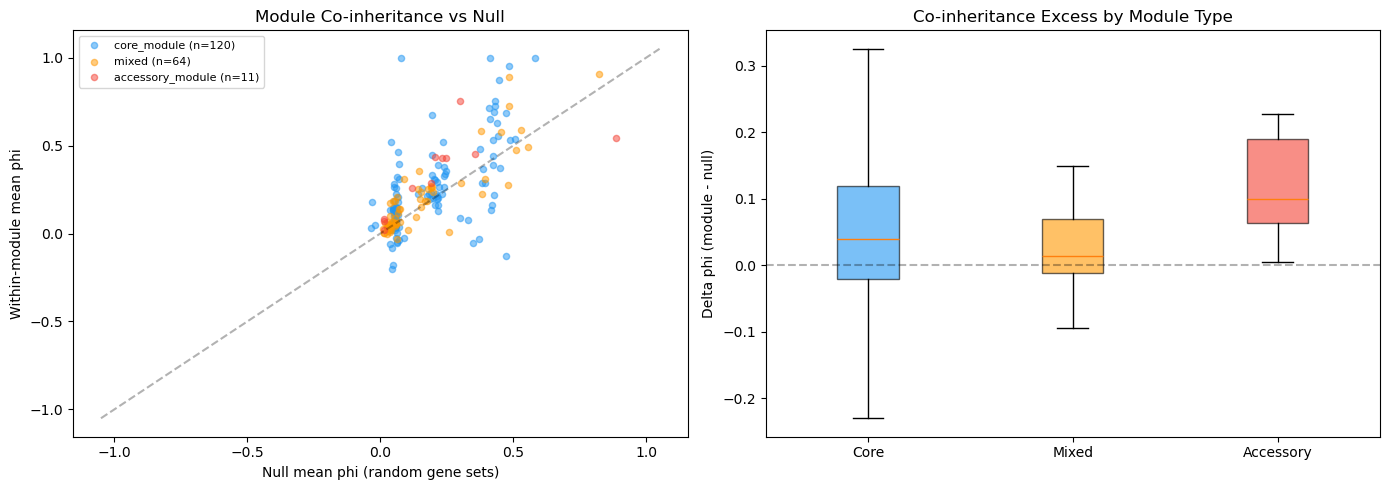

In [5]:
if all_module_results:
    module_df = pd.DataFrame(all_module_results)
    valid = module_df.dropna(subset=['mean_phi', 'null_mean'])

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Panel A: Module phi vs null, colored by type
    colors = {'core_module': '#2196F3', 'mixed': '#FF9800', 'accessory_module': '#F44336'}
    for mt, color in colors.items():
        sub = valid[valid['module_type'] == mt]
        axes[0].scatter(sub['null_mean'], sub['mean_phi'], c=color, alpha=0.5,
                        label=f'{mt} (n={len(sub)})', s=20)

    lim = max(abs(valid['mean_phi'].max()), abs(valid['null_mean'].max())) + 0.05
    axes[0].plot([-lim, lim], [-lim, lim], 'k--', alpha=0.3)
    axes[0].set_xlabel('Null mean phi (random gene sets)')
    axes[0].set_ylabel('Within-module mean phi')
    axes[0].set_title('Module Co-inheritance vs Null')
    axes[0].legend(fontsize=8)

    # Panel B: Delta by module type (box plot)
    type_order = ['core_module', 'mixed', 'accessory_module']
    box_data = [valid[valid['module_type'] == mt]['delta'].dropna() for mt in type_order]
    bp = axes[1].boxplot(box_data, labels=['Core', 'Mixed', 'Accessory'],
                         patch_artist=True, showfliers=False)
    for patch, color in zip(bp['boxes'], ['#2196F3', '#FF9800', '#F44336']):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)
    axes[1].set_ylabel('Delta phi (module - null)')
    axes[1].set_title('Co-inheritance Excess by Module Type')

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'module_coinheritance.png', dpi=150, bbox_inches='tight')
    plt.show()

In [6]:
print('=' * 60)
print('NB03 SUMMARY: Module Co-inheritance')
print('=' * 60)
if all_module_results:
    module_df = pd.DataFrame(all_module_results)
    valid = module_df.dropna(subset=['mean_phi', 'null_mean'])
    print(f'Organisms: {valid["orgId"].nunique()}')
    print(f'Modules analyzed: {len(valid)}')
    print(f'Mean within-module phi: {valid["mean_phi"].mean():.4f}')
    print(f'Mean null phi: {valid["null_mean"].mean():.4f}')
    print(f'Mean delta: {valid["delta"].mean():.4f}')
    print(f'Significant (p<0.05): {(valid["pval"] < 0.05).sum()}/{len(valid)}')
    if 'sig_fdr' in valid.columns:
        print(f'Significant after FDR (q<0.05): {valid["sig_fdr"].sum()}/{len(valid)}')
    print(f'Null permutations: 1000')
else:
    print('No data')
print('=' * 60)

NB03 SUMMARY: Module Co-inheritance
Organisms: 6
Modules analyzed: 195
Mean within-module phi: 0.2292
Mean null phi: 0.1765
Mean delta: 0.0527
Significant (p<0.05): 51/195
Null permutations: 1000
